In [1]:
# number of CPUs to be used
NCPU=20

## Load and process the dataset

In [2]:
import gzip, json
import numpy as np
import utils 
from sklearn.model_selection import train_test_split

# 20 standard amino acids
aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# load
dataset = utils.load_phipsi()

# 90% train, 10% test
train,test = train_test_split(dataset, test_size=0.1, random_state=42)


## Clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss


In [4]:
WINDOW = 15

X_train = utils.getX(train, WINDOW)
X_test = utils.getX(test, WINDOW)

phi_ref = utils.getPHI(test, WINDOW)
psi_ref = utils.getPSI(test, WINDOW)


In [5]:
# cluster
KM = KMeans(n_clusters=20, max_iter=5, random_state=42, n_jobs=NCPU)
KM.fit(np.vstack([item['avec'] for item in train]))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5,
    n_clusters=20, n_init=10, n_jobs=20, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

## Train a neural network

In [6]:
from sklearn.neural_network import MLPClassifier

Y_train = utils.getY(train, WINDOW, KM)
Y_test = utils.getY(test, WINDOW, KM)

# perceptron with one 100-nodes hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(100),max_iter=25,verbose=1)
mlp.fit(X_train, Y_train)

Iteration 1, loss = 2.06234899
Iteration 2, loss = 2.00289384
Iteration 3, loss = 1.99186702
Iteration 4, loss = 1.98620101
Iteration 5, loss = 1.98261269
Iteration 6, loss = 1.98016147
Iteration 7, loss = 1.97814494
Iteration 8, loss = 1.97673062
Iteration 9, loss = 1.97541911
Iteration 10, loss = 1.97439687
Iteration 11, loss = 1.97339915
Iteration 12, loss = 1.97273162
Iteration 13, loss = 1.97210219
Iteration 14, loss = 1.97157484
Iteration 15, loss = 1.97101501
Iteration 16, loss = 1.97062976
Iteration 17, loss = 1.97021937
Iteration 18, loss = 1.96993714
Iteration 19, loss = 1.96955695
Iteration 20, loss = 1.96930906
Iteration 21, loss = 1.96899499
Iteration 22, loss = 1.96875301
Iteration 23, loss = 1.96853862
Iteration 24, loss = 1.96827851
Iteration 25, loss = 1.96820908


/projects/omics/prog/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=25, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=1, warm_start=False)

In [10]:
# calculate weighted averages
avec = np.matmul(mlp.predict_proba(X_test), KM.cluster_centers_)

# vectors of weighted averages avec[..] might not represent
# true sin(.),cos(.) pairs any more -- need to normalize them
norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)

# error estimates
print("rmse(phi)= {:.3f}".format(utils.ang_rmse(phi_ref, phi_pred) * 180 / np.pi))
print("rmse(psi)= {:.3f}".format(utils.ang_rmse(psi_ref, psi_pred) * 180 / np.pi))


rmse(phi)= 43.090
rmse(psi)= 81.376


### Figures

In [11]:
# errors on a per cluster basis
rmse_phi_clust = {}
rmse_psi_clust = {}

for idx in range(0,KM.cluster_centers_.shape[0]):
    rmse_phi_clust[idx] = utils.ang_rmse(phi_ref[Y_test == idx], phi_pred[Y_test == idx])
    rmse_psi_clust[idx] = utils.ang_rmse(psi_ref[Y_test == idx], psi_pred[Y_test == idx])

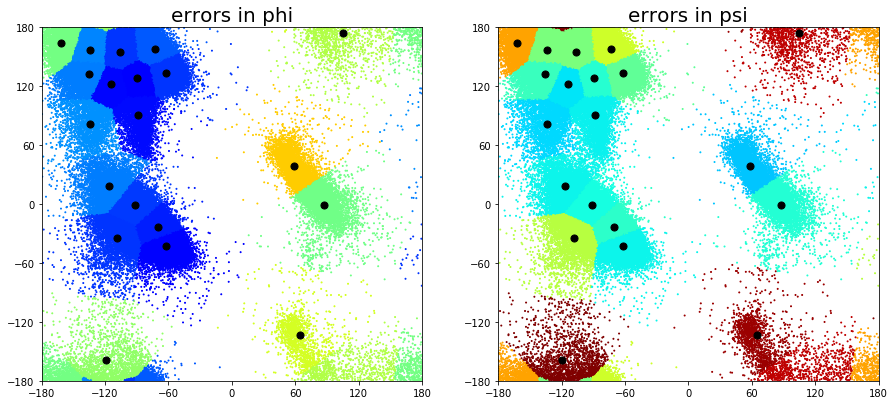

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# cluster centers
cent = KM.cluster_centers_
cphi = np.arctan2(cent[:,0], cent[:,1]) * 180 / np.pi
cpsi = np.arctan2(cent[:,2], cent[:,3]) * 180 / np.pi

# color vectors (rmse)
col_phi = np.array([rmse_phi_clust[idx] for idx in Y_test]) * 180 / np.pi
col_psi = np.array([rmse_psi_clust[idx] for idx in Y_test]) * 180 / np.pi

matplotlib.rcParams['image.cmap'] = 'jet'

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6.5)

# set style
for col in (0,1):
    ax[col].set_xlim([-180,180])
    ax[col].set_ylim([-180,180])
    ax[col].set_xticks((-180,-120,-60,0,60,120,180))
    ax[col].set_yticks((-180,-120,-60,0,60,120,180))

ax[0].set_title("errors in phi", fontsize=20)
ax[0].scatter(phi_ref*180/np.pi, psi_ref*180/np.pi, c=col_phi, s=1, vmin=0, vmax=180)
ax[0].scatter(cphi, cpsi, c='black', s=50)

ax[1].set_title("errors in psi", fontsize=20)
ax[1].scatter(phi_ref*180/np.pi, psi_ref*180/np.pi, c=col_psi, s=1, vmin=0, vmax=180)
ax[1].scatter(cphi, cpsi, c='black', s=50)

plt.show()